In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 1. Préparation des données
Chargement du dataset IMDB. 

In [43]:
reviews = pd.read_csv('IMDB Dataset.csv', engine='python', error_bad_lines=False)
reviews.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Pour construire un modèle de classification binaire, la colonne de sentiment doit être convertie en valeurs numériques telles que le sentiment "positif" est considéré comme 1 et le sentiment "négatif" comme 0. Nous pouvons y parvenir facilement en modifiant la colonne DataFrame de pandas à l'aide de <b>np.where() </b>:

In [44]:
reviews['sentiment'] = np.where(reviews['sentiment'] == 'positive', 1, 0)

La prochaine chose que nous devons faire est de convertir les  <b> reviews </b> et les <b> sentiments </b> en tableaux NumPy, car les méthodes de prétraitement favorisent des tableaux au lieu des séries pandas :

In [45]:
sentences = reviews['review'].to_numpy()
labels = reviews['sentiment'].to_numpy()

Avant tout prétraitement, nous devons diviser notre dataset en instances d'entraînement et de test. Nous utiliserons 80 % des données pour l'entrainement et 20 % des données pour le test :

In [46]:
x_train, x_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2)
print("Training Data Input Shape: ", x_train.shape)
print("Training Data Output Shape: ", y_train.shape)
print("Testing Data Input Shape: ", x_test.shape)
print("Testing Data Output Shape: ", y_test.shape)

Training Data Input Shape:  (40000,)
Training Data Output Shape:  (40000,)
Testing Data Input Shape:  (10000,)
Testing Data Output Shape:  (10000,)


Pour construire un modèle mathématique, nous devons convertir des données textuelles (reviews) en valeurs numériques. Cette opération est appelée <b> tokenisation </b>.

Pour la plupart des tâches du TAL (NLP), la tokenisation est effectuée sur l'ensemble du corpus de texte, qui comprend essentiellement toutes les données d'entrainement.

Lors de la tokenisation, les phrases sont segmentées en un ensemble de mots individuels, puis des caractéristiques statistiques sont calculées pour chaque mot, telles que :

$\bullet$ <b>word_counts</b> : Représente le dictionnaire de mots existant dans le corpus de texte. Chaque mot est associé à son nombre d'apparitions dans le corpus de texte. 

$\bullet$ <b>word_docs </b> : Représente le dictionnaire de mots existant dans le corpus de texte. Chaque mot est associé au nombre de phrases le contenant dans le corpus de texte .

$\bullet$ <b>word_index </b> : Un indece unique attribué à chaque mot du dictionnaire de mots.

$\bullet$ <b>document_count </b> : Représente le nombre de phrases (documents) du corpus de texte.

Pour effectuer la tokenisation des données d'apprentissage, nous devons spécifier la taille du vocabulaire. Specifiquement, la taille du vocabulaire est le nombre de mots à prendre en les triant par ordre décroissant de leur fréquence d'apparition.

Ici, nous ne prenons que les 10 000 premiers mots en fonction de leur occurences dans le dataset d'apprentissage. De plus, nous avons spécifié oov_tok comme "< OOV >" qui remplacera tout mot inconnu dans le corpus de texte.


In [47]:
vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

Une fois que nous avons défini les hyperparamètres pour Tokenizer(), nous devons les adapter aux données d'entraînement à l'aide de <b>fit_on_texts() </b> :

In [48]:
tokenizer.fit_on_texts(x_train)
print("Nombre de phrases (documents): ", tokenizer.document_count)
print("Nombre de mots (tokens): ", tokenizer.num_words)

Nombre de phrases (documents):  40000
Nombre de mots (tokens):  10000


Nous pouvons visualisé l'indice de chaque mot du dictionnaire. 

In [49]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'a': 4,
 'of': 5,
 'to': 6,
 'is': 7,
 'br': 8,
 'in': 9,
 'it': 10,
 'i': 11,
 'this': 12,
 'that': 13,
 'was': 14,
 'as': 15,
 'for': 16,
 'with': 17,
 'movie': 18,
 'but': 19,
 'film': 20,
 'on': 21,
 'not': 22,
 'you': 23,
 'are': 24,
 'his': 25,
 'have': 26,
 'be': 27,
 'one': 28,
 'he': 29,
 'all': 30,
 'at': 31,
 'by': 32,
 'an': 33,
 'they': 34,
 'so': 35,
 'who': 36,
 'from': 37,
 'like': 38,
 'or': 39,
 'just': 40,
 'her': 41,
 'about': 42,
 'out': 43,
 'if': 44,
 "it's": 45,
 'has': 46,
 'there': 47,
 'some': 48,
 'what': 49,
 'good': 50,
 'more': 51,
 'very': 52,
 'when': 53,
 'up': 54,
 'no': 55,
 'time': 56,
 'even': 57,
 'my': 58,
 'would': 59,
 'she': 60,
 'which': 61,
 'only': 62,
 'story': 63,
 'really': 64,
 'see': 65,
 'their': 66,
 'can': 67,
 'had': 68,
 'me': 69,
 'were': 70,
 'well': 71,
 'much': 72,
 'than': 73,
 'we': 74,
 'been': 75,
 'bad': 76,
 'get': 77,
 'do': 78,
 'will': 79,
 'great': 80,
 'also': 81,
 'other': 82,
 '

Nous pouvons visualiser le nombre d'occurence de chaque mot dans le dictionnaire global :

In [50]:
tokenizer.word_counts

OrderedDict([('if', 27215),
             ("you're", 3037),
             ('looking', 4048),
             ('for', 70058),
             ('an', 34368),
             ('accurate', 486),
             ('portrayal', 821),
             ('of', 231162),
             ('che', 141),
             ('guevara', 29),
             ('the', 532234),
             ('cuban', 58),
             ('revolutionary', 172),
             ('who', 32549),
             ('helped', 506),
             ('aid', 155),
             ('fidel', 21),
             ('castro', 41),
             ('in', 149043),
             ('his', 45881),
             ('bid', 26),
             ('power', 1494),
             ("you'd", 617),
             ('better', 9176),
             ('read', 2986),
             ('up', 21039),
             ('on', 54326),
             ('history', 2031),
             ('or', 28708),
             ('even', 19874),
             ('type', 1834),
             ('name', 2614),
             ('a', 257533),
             ('search', 508)

Nous pouvons également voir le nombre de phrases contenant un mot :

In [51]:
tokenizer.word_docs

defaultdict(int,
            {'this': 36218,
             'its': 8156,
             'travesty': 130,
             'time': 13788,
             "you're": 2499,
             'che': 36,
             'watch': 8642,
             'looking': 3523,
             'you': 20762,
             'br': 23355,
             'star': 2496,
             'watching': 6019,
             'helped': 481,
             'accurate': 445,
             'but': 28621,
             'up': 13800,
             'can': 12462,
             'an': 19426,
             'unless': 1030,
             'aid': 150,
             'the': 39652,
             'not': 23790,
             'all': 20681,
             'fidel': 16,
             'production': 2377,
             'portrayal': 755,
             'do': 10616,
             'their': 11054,
             'course': 3345,
             'at': 20484,
             'engine': 74,
             "it's": 14520,
             'after': 9041,
             'good': 15202,
             'unconvincing': 275,
     

Une fois que nous avons tokenisé l'ensemble du corpus de texte, nous devons convertir chaque review en une séquence numérique à l'aide du tokenizer :

In [52]:
train_sequences = tokenizer.texts_to_sequences(x_train)
print("Le premier review du dataset d'entrainement en indices : ", train_sequences[0])

Le premier review du dataset d'entrainement en indices :  [44, 336, 257, 16, 33, 1728, 1113, 5, 4634, 1, 2, 8697, 3999, 36, 1679, 4343, 1, 1, 9, 25, 1, 16, 658, 1427, 126, 341, 54, 21, 8697, 489, 39, 57, 536, 9, 25, 386, 21, 4, 1670, 6894, 23, 24, 21, 2, 2950, 101, 30, 8, 8, 19, 837, 23, 78, 78, 22, 104, 4634, 8, 8, 901, 5, 267, 23, 40, 178, 4, 50, 418, 8, 8, 30, 2, 2089, 5, 2, 56, 3, 9049, 519, 4634, 66, 2006, 16, 249, 20, 5, 2, 2113, 3, 55, 577, 26, 23, 106, 12, 4884, 94, 2250, 24, 1, 31, 116, 1, 7, 57, 2641, 15, 4, 3627, 3, 15, 16, 1, 1, 1, 5055, 8, 8, 38, 11, 302, 44, 23, 178, 4, 50, 418, 8, 8, 45, 38, 149, 4, 1029, 354, 199, 2, 2824, 1233, 3, 1105, 3441, 8, 8, 28, 324, 8, 8, 11, 577, 44, 6954, 67, 78, 1786, 1149, 4041, 97]


Chaque review des données d'entrainement est converté en une sequence numérique qui peut être introduite au modèle mathèmatique à des fins d'entrainement.

Cependant, le texte de chaque review a une longueure en mots différentes et produira une longueur de séquence numérique différente de celle des autres révisions.

Nous devons donc limiter les longueurs de séquence à une valeur constante pour chaque review. Nous spécifierons une longueur de séquence de 200 mots pour chaque review. 

Les séquences numériques ayant des longueurs supérieures à 200 seront tronquées à la fin, tandis que celles ayant des longueurs inférieures à 200 seront complétées par des zéros à la fin.

Nous pouvons maintenant spécifier le padding de séquence pour les séquences numériques des reviews. 


In [53]:
sequence_length = 200
train_padded = pad_sequences(train_sequences, maxlen=sequence_length, padding='post', truncating='post')

Une fois que nous avons fait le pré-traitement sur les données d'entrainement, nous devons répéter les mêmes étapes pour les données de test :

In [54]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen=sequence_length, padding='post', truncating='post')

Avec la tokenisation, la conversion de séquence et le padding, nous en avons terminé avec le prétraitement des reviews.

Passons maintenant à la construction du modèle LSTM réel pour l'analyse des sentiments

## 2. Analyse des sentiments à l'aide de LSTM


In [55]:
model = Sequential()

Dans un premier temps, nous allons ajouter une couche d'embedding qui convertira chaque mot en un vecteur dense de dimensions d'emdedding spécifiées dans les hyperparamètres de la couche :

In [56]:
embedding_dim = 16
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))

Ensuite, nous devons spécifier la couche Bidirectional() et la couche LSTM avec une taille d'unité spécifiée dans la couche LSTM.

L'un des avantages de l'utilisation de LSTM bidirectionnel est qu'il se souvient de la sortie du passé vers le futur ainsi que du futur vers le passé. Cette technique peut aboutir à des modèles plus robustes pour l'analyse des séries chronologiques.

In [57]:
lstm_out = 32
model.add(Bidirectional(LSTM(lstm_out)))

Ensuite, nous spécifierons une couche entièrement connectée ayant 10 unités et une activation "relu" et nous ajouterons une couche de sortie ayant seulement 1 unité et une activation "sigmoïde". Cette couche affichera la probabilité qu'une entrée appartienne à 1 (ou positif).

In [58]:
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Nous compilons le modèle et nous affichons sont résumé :

In [59]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 16)           160000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 173,205
Trainable params: 173,205
Non-trainable params: 0
_________________________________________________________________
None


Disons simplement que nous avons spécifié le nombre d'époques à 10 alors que notre modèle a convergé vers une perte de validation minimale après 2 époques. Les 8 époques restantes n'auront tendance qu'à surajuster le modèle sur les données d'apprentissage. Alors, comment allons-nous éviter cette situation ?

C'est simple. Nous spécifions le rappel pour <b>EarlyStopping()</b>, qui arrêtera la formation du modèle après que le modèle n'a pas réussi à minimiser la valeur de perte de validation après le non indiqué d'époques dans les paramètres de rappel.

Parallèlement au rappel pour EarlyStopping(), vous pouvez spécifier le ModelCheckpoint() pour surveiller la perte après chaque époque et enregistrer le meilleur modèle en termes de perte de validation.

In [60]:
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=2), model_checkpoint_callback]

In [61]:
history = model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test), callbacks=callbacks)

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.7868

1250/1250 [==============================] - 151s 116ms/step - loss: 0.4337 - accuracy: 0.7868 - val_loss: 0.3160 - val_accuracy: 0.8705
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.8962

1250/1250 [==============================] - 145s 116ms/step - loss: 0.2650 - accuracy: 0.8962 - val_loss: 0.2910 - val_accuracy: 0.8778
Epoch 3/10
1250/1250 [==============================] - 128s 102ms/step - loss: 0.2184 - accuracy: 0.9158 - val_loss: 0.3132 - val_accuracy: 0.8646
Epoch 4/10
1250/1250 [==============================] - 127s 101ms/step - loss: 0.1842 - accuracy: 0.9317 - val_loss: 0.3351 - val_accuracy: 0.8673


In [62]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  0.433716  0.786825  0.316037        0.8705
1  0.265040  0.896200  0.290956        0.8778
2  0.218372  0.915850  0.313205        0.8646
3  0.184188  0.931675  0.335067        0.8673


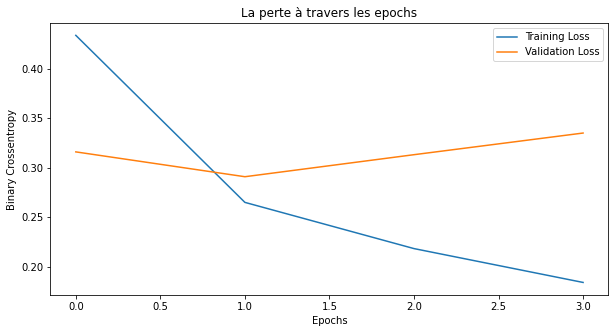

In [64]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('La perte à travers les epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

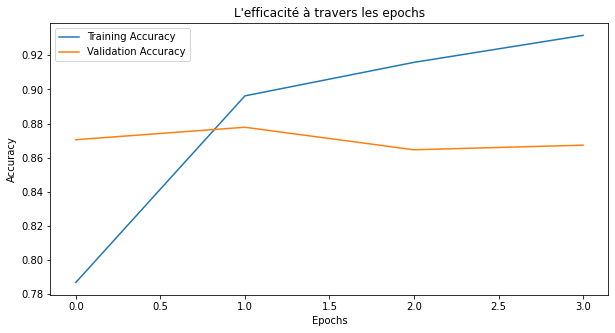

In [65]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title("L'efficacité à travers les epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [66]:
sentences =["i loved it! highly recommend it to anyone and everyone looking for a great movie to watch.", 
            "this was awful! i hated it so much, nobody should watch this. the acting was terrible, the music was terrible, overall it was just bad.", 
            "I thought this was a wonderful way to spend time"]

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=sequence_length, padding='post', truncating='post')
print (model.predict(padded))


1/1 [==============================] - 1s 1s/step
[[9.907047e-01]
 [9.516711e-04]
 [9.630498e-01]]
